In [1]:
import os
print(os.getcwd())
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader

from notebooks.energy_model_retrain.load_ckpt import define_model


from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def get_model_prediction(input_ckpt_path, input_data_loader):
    _model, _, _ = define_model(input_ckpt_path)
    _logits=[]
    _proba=[]
    softmax=Softmax(dim=-1)
    with torch.no_grad():
        for batch in tqdm(input_data_loader):
            _input_ids = batch['input_ids'].to(DEVICE)
            _attention_mask = batch['attention_mask'].to(DEVICE)
            _labels = batch['labels'].to(DEVICE)
            _outputs = _model(_input_ids, attention_mask=_attention_mask, labels=_labels)
            _logits.append(_outputs)
            _proba.extend(softmax(_outputs['logits'])[:,1].cpu().numpy())
    return _proba

def evaluate_model(input_pred_data, input_column_name):
    _rvalue, _ = pearsonr(input_pred_data['toxicity'], input_pred_data[input_column_name])
    # print("Pearson R: %.3f" % rvalue)

    _RMSE = mean_squared_error(input_pred_data['toxicity'], input_pred_data[input_column_name])**0.5
    # print("RMSE: %.3f" % RMSE)

    _MAE = mean_absolute_error(input_pred_data['toxicity'], input_pred_data[input_column_name])
    # print("MAE: %.3f" % MAE)
    
    return _rvalue, _RMSE, _MAE


def plot_heatmap(input_pred_data, input_pred_data_name, input_column_name, input_plot_axis, input_cbar, input_cbar_axis=None):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_pred_data = input_pred_data[['toxicity', input_column_name]].copy()
    # bin toxicity columns values
    copy_pred_data['toxicity_cat']=pd.cut(copy_pred_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    copy_pred_data['mod_proba_cat']=pd.cut(copy_pred_data[input_column_name], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    
    heatmap_data = copy_pred_data.groupby(['toxicity_cat', 'mod_proba_cat']).size().unstack(0).apply(lambda x: x/(x.sum()+0.1), axis=0)
    # print(heatmap_data)
    sns.heatmap(heatmap_data, ax=input_plot_axis, cbar=input_cbar, cbar_ax=input_cbar_axis, cbar_kws={ "orientation": "horizontal" })
    input_plot_axis.set_title(f'Test data: {input_pred_data_name}, Model: {input_column_name}')
    
def plot_boxplot(input_pred_data, input_pred_data_name, input_column_name, input_plot_axis):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_pred_data = input_pred_data[['toxicity', input_column_name]].copy()
    # bin toxicity columns values
    copy_pred_data['toxicity_cat']=pd.cut(copy_pred_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    copy_pred_data['mod_proba_cat']=pd.cut(copy_pred_data[input_column_name], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    
    sns.boxplot(data = copy_pred_data, x = 'toxicity_cat', y=input_column_name, ax=input_plot_axis)
    input_plot_axis.set_title(f'Test data: {input_pred_data_name}, Model: {input_column_name}')
    # input_plot_axis.set_xticklabels(rotation=45)
    input_plot_axis.set_ylim(top=1)
    input_plot_axis.set_ylabel('')
    
def plot_train_dist(input_train_data, input_column_name, input_plot_axis):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_train_data = input_train_data[['toxicity']].copy()
    # bin toxicity columns values
    copy_train_data['toxicity_cat']=pd.cut(copy_train_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    # barplot_data = copy_train_data.groupby('toxicity_cat').apply(lambda x: x.size/len(copy_train_data)).reset_index().rename(columns={0: 'count'})
    barplot_data = copy_train_data.groupby('toxicity_cat').apply(lambda x: x.size).reset_index().rename(columns={0: 'count'})
    
    sns.barplot(data = barplot_data, x = 'toxicity_cat', y = 'count', ax=input_plot_axis)
    input_plot_axis.set_title(f'Train data composition (count) for Model: {input_column_name}')
    input_plot_axis.set_ylabel('')
    
BATCH_SIZE=64
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

/home/hyeryungson/mucoco
cuda


In [2]:
# load tokenizer
ckpt_path='/home/hyeryungson/mucoco/models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
_, _, tokenizer = define_model(ckpt_path)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


0.8719356404051346 0.15487411579715213 0.1177929600787238
toxicity_cat
[0.0, 0.1)    0.12
[0.1, 0.2)    0.14
[0.2, 0.3)    0.15
[0.3, 0.4)    0.17
[0.4, 0.5)    0.17
[0.5, 0.6)    0.17
[0.6, 0.7)    0.14
[0.7, 0.8)    0.11
[0.8, 0.9)    0.11
[0.9, 1.0)    0.12
[1.0, 1.1)    0.26
Name: rmse_balanced, dtype: float64


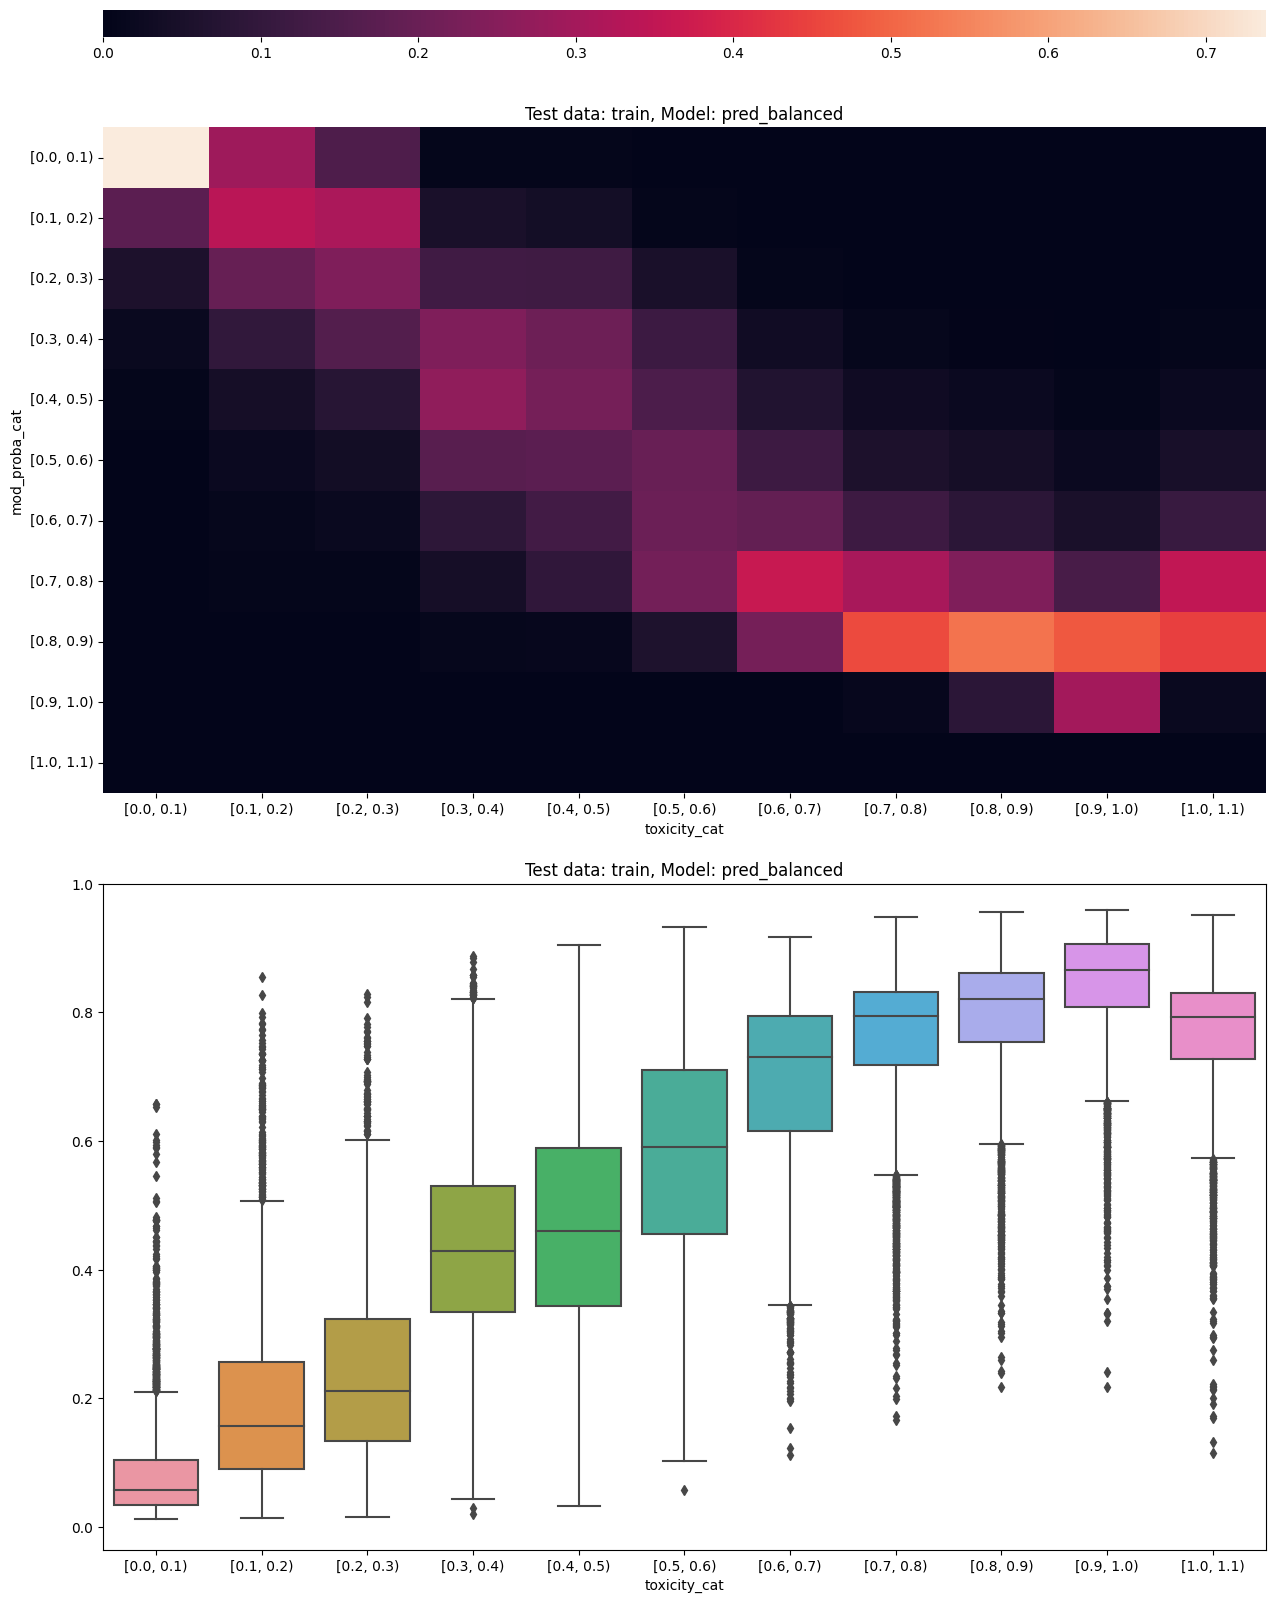

In [11]:
# balanced 
dataset_name = 'train'
model_name = 'balanced'

train=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train.jsonl",lines=True)
train = train.loc[~train['toxicity'].isna()]

# create dataset, dataloader
train_enc = tokenizer(train['text'].tolist(), padding=True, truncation=True)
train_data = Dataset(train_enc, [0]*len(train['text']))
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

# get prediction
ckpt_path='/home/hyeryungson/mucoco/models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
train[f'pred_{model_name}'] = get_model_prediction(ckpt_path, train_dataloader)

train[['text', f'pred_{model_name}']].to_csv(f'/home/hyeryungson/mucoco/notebooks/results/train_{model_name}_preds.csv', index=False)

rvalue, RMSE, MAE = evaluate_model(train, f'pred_{model_name}')
print(rvalue, RMSE, MAE)

train['toxicity_cat']=pd.cut(train['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
rmse = train.groupby('toxicity_cat').apply(lambda x: round(mean_squared_error(x['toxicity'], x[f'pred_{model_name}'])**(1/2), 2))
rmse.name = f'rmse_{model_name}'
print(rmse)

fig, axes = plt.subplots(nrows=3, ncols=1, sharey='row', figsize=[15, 20], height_ratios=[0.02, 0.49, 0.49])
plot_heatmap(train, dataset_name, f'pred_{model_name}', axes[1], True, axes[0])
plot_boxplot(train, dataset_name, f'pred_{model_name}', axes[2])
plt.show()

In [ ]:
# balanced 
dataset_name = 'train'
model_name = 'add'

train=pd.read_json("/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_mucoco+add.jsonl",lines=True)
train = train.loc[~train['toxicity'].isna()]

# create dataset, dataloader
train_enc = tokenizer(train['text'].tolist(), padding=True, truncation=True)
train_data = Dataset(train_enc, [0]*len(train['text']))
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

# get prediction
ckpt_path='/home/hyeryungson/mucoco/models/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
train[f'pred_{model_name}'] = get_model_prediction(ckpt_path, train_dataloader)

train[['text', f'pred_{model_name}']].to_csv(f'/home/hyeryungson/mucoco/notebooks/results/train_{model_name}_preds.csv', index=False)

rvalue, RMSE, MAE = evaluate_model(train, f'pred_{model_name}')
print(rvalue, RMSE, MAE)

train['toxicity_cat']=pd.cut(train['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
rmse = train.groupby('toxicity_cat').apply(lambda x: round(mean_squared_error(x['toxicity'], x[f'pred_{model_name}'])**(1/2), 2))
rmse.name = f'rmse_{model_name}'
print(rmse)

fig, axes = plt.subplots(nrows=3, ncols=1, sharey='row', figsize=[15, 20], height_ratios=[0.02, 0.49, 0.49])
plot_heatmap(train, dataset_name, f'pred_{model_name}', axes[1], True, axes[0])
plot_boxplot(train, dataset_name, f'pred_{model_name}', axes[2])
plt.show()